In [413]:
import os
import sys
import math
import logging
from pathlib import Path
from datetime import datetime

import numpy as np
import scipy as sp
from scipy import stats
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [414]:
np.random.seed(42)

# Honey, I shrunk the target variable!

Download the data from [Kaggle used-cars database](https://www.kaggle.com/orgesleka/used-cars-database), unzip it and put it under `../data/raw`

In [415]:
!ls ../data/raw/  # this should show "autos.csv"

autos.csv


In [416]:
data_dir = Path('../data/raw')
autos_csv = data_dir / Path('autos.csv')

In [417]:
df = pd.read_csv(autos_csv, encoding='cp850')
for col in df.columns:
    print(col)

dateCrawled
name
seller
offerType
price
abtest
vehicleType
yearOfRegistration
gearbox
powerPS
model
kilometer
monthOfRegistration
fuelType
brand
notRepairedDamage
dateCreated
nrOfPictures
postalCode
lastSeen


Let's concentrate only on working cars in a reasonable price range which are sold

In [418]:
df = df.query('price <= 50_000 and notRepairedDamage == "nein" and price > 200 and offerType == "Angebot"')

In [419]:
df.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,256640.000000,256640.000000,256640.000000,256640.000000,256640.000000,256640.0,256640.000000
mean,6704.024314,2004.127229,124.656901,123263.462438,6.166771,0.0,51630.454462
std,7174.017565,27.962960,162.600851,40189.158129,3.491749,0.0,25870.586593
min,205.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1800.000000,2000.000000,75.000000,100000.000000,3.000000,0.0,31139.000000
50%,4100.000000,2004.000000,116.000000,150000.000000,6.000000,0.0,50823.000000
75%,8950.000000,2009.000000,150.000000,150000.000000,9.000000,0.0,72622.000000
max,50000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [420]:
# create 1000 Euro bins for price-ranges
bins = 1000*np.arange(50)

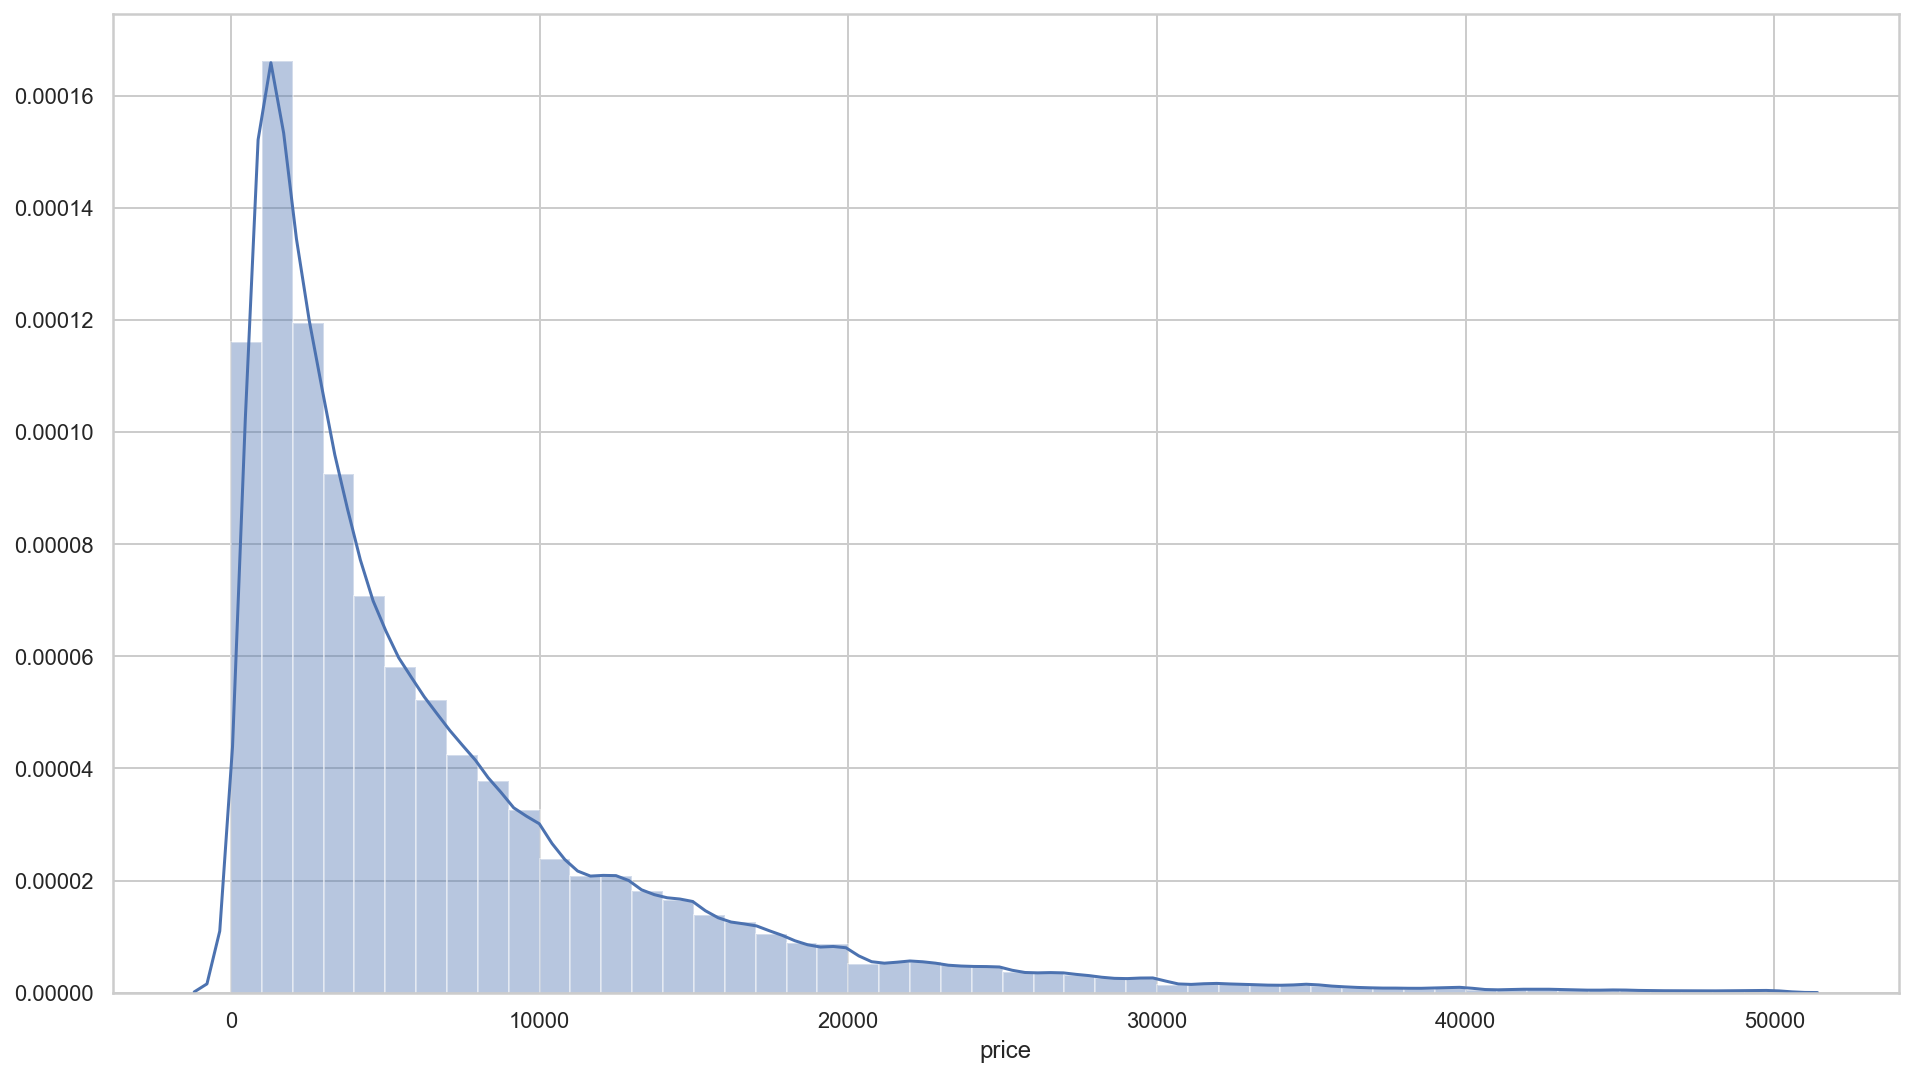

In [421]:
sns.distplot(df.price, bins=bins);

The price looks definitely not normal distributed rather log-normal distributed. Let's check that visually.

We fit a log-normal distribution, sample from it and see it it looks similar

In [422]:
shape, loc, scale = stats.lognorm.fit(df.price, floc=0.)
dist = stats.lognorm(shape, loc, scale)
rvs = dist.rvs(100_000)

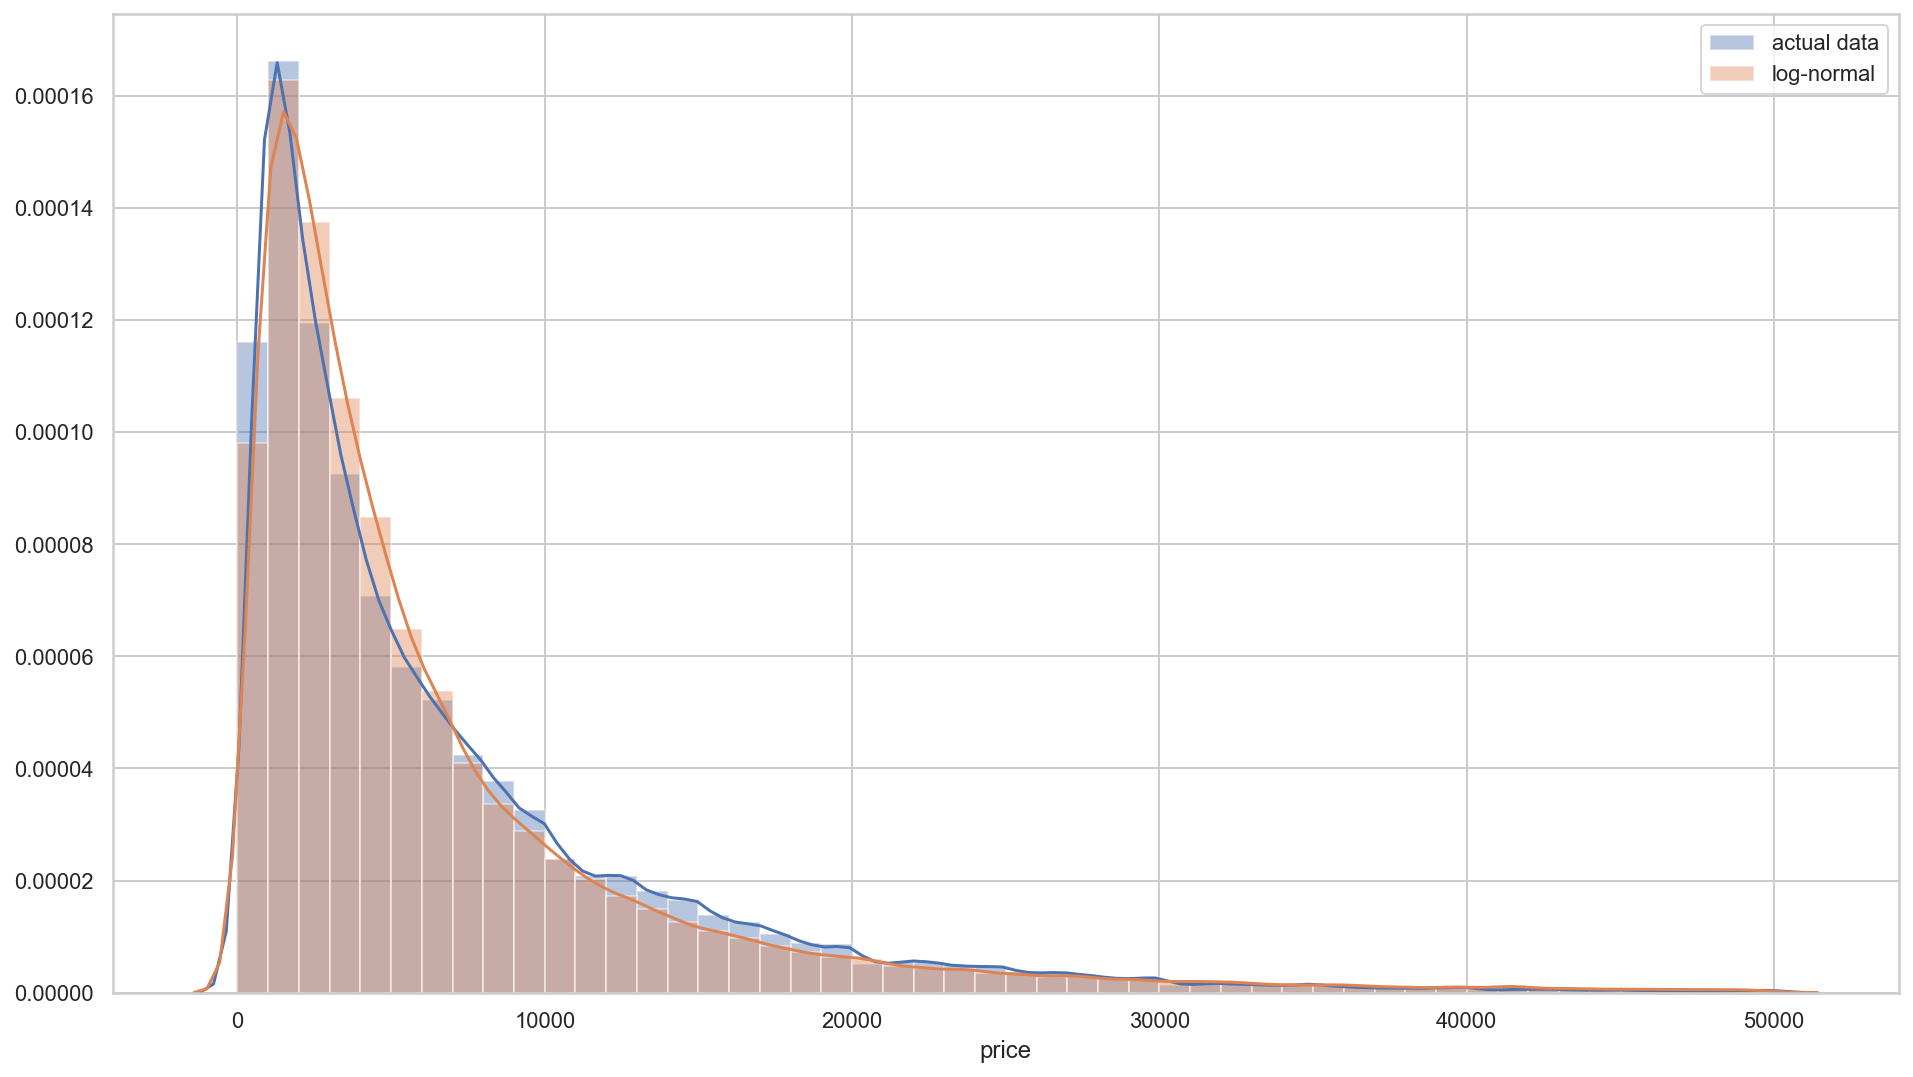

In [423]:
sns.distplot(df.price, bins=bins, label='actual data')
sns.distplot(rvs[rvs<50_000], bins=bins, label='log-normal')
plt.legend();

## Is the target variable of a linear model always normally distributed?

In [424]:
# Use some simple linear model to generate the target variable
N = 10000
x = np.random.randint(2, size=N)
y = x + 0.3*np.random.randn(N)

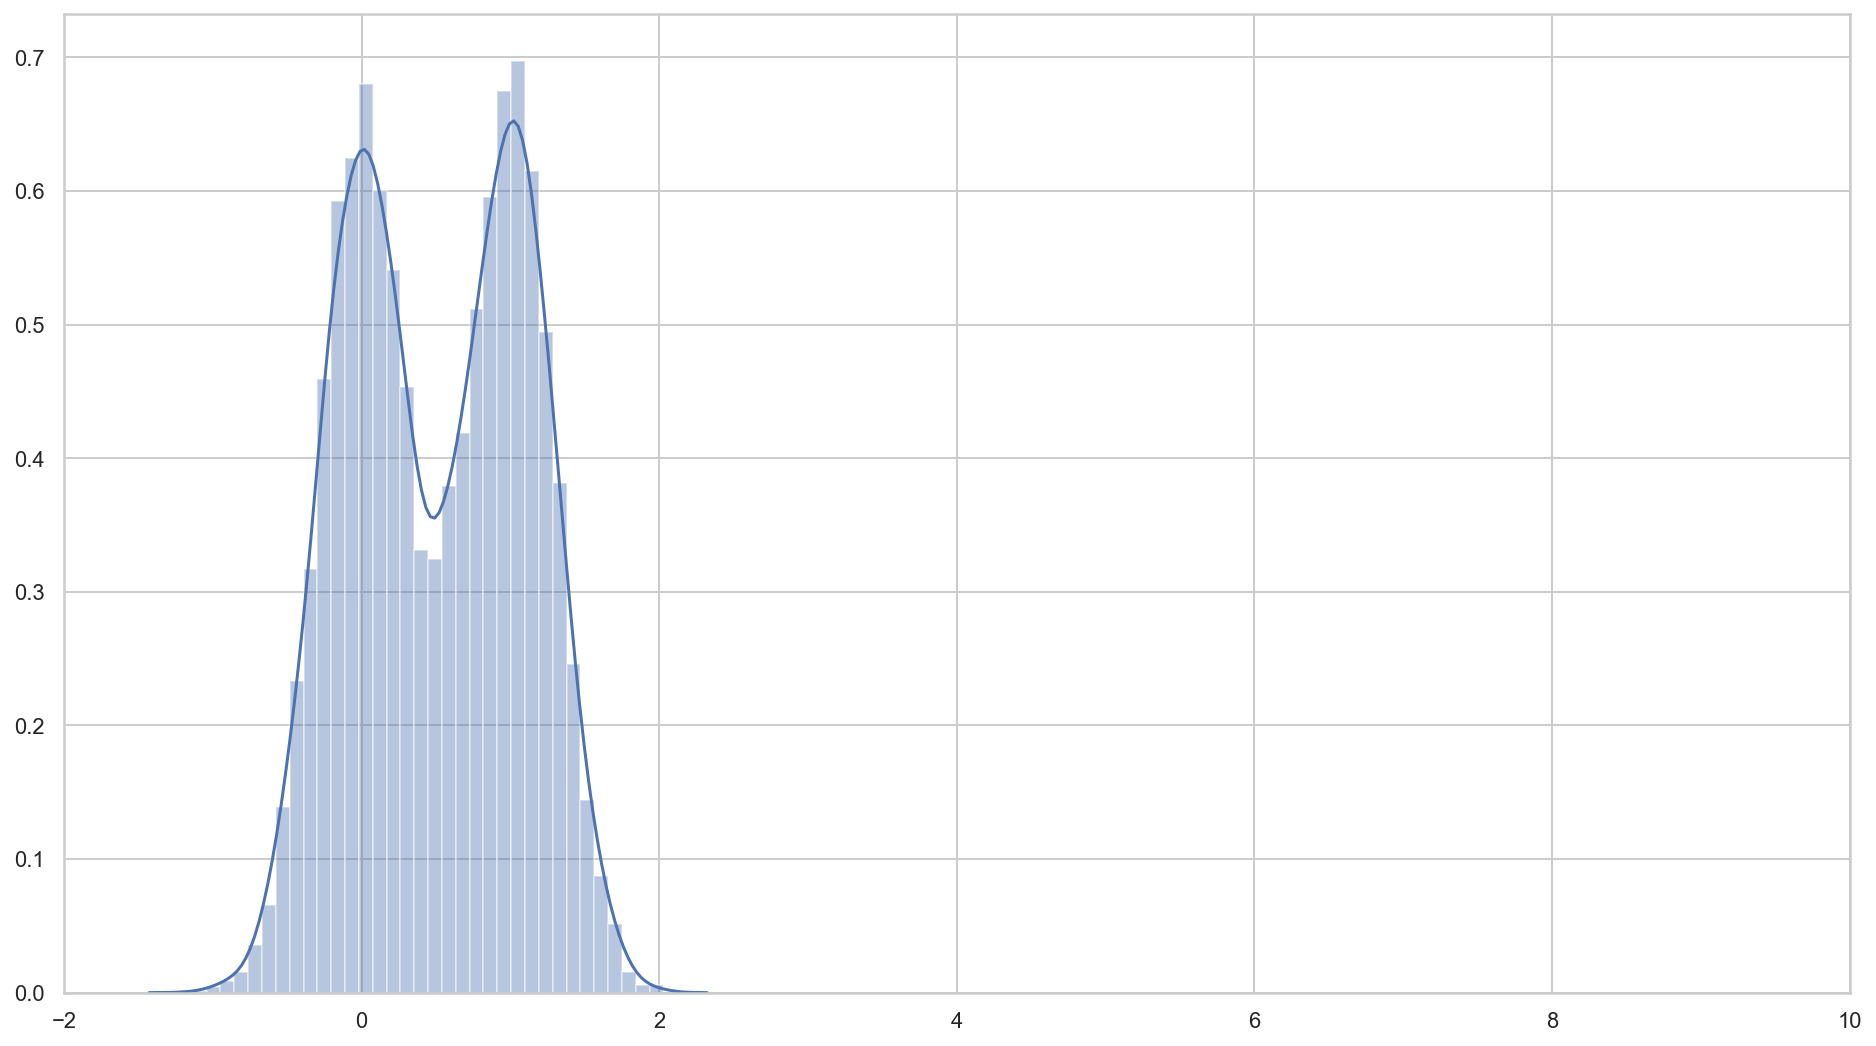

In [425]:
# Obviously, the outcome of a linear model doesn't have to be normally distributed.
sns.distplot(y)
plt.xlim(-2, 10);

## Fitting the MAE (aka l1-norm) and RMSE (aka l2 norm)

In [426]:
y = df.price.to_numpy()

def rmse(yhat, y):
    if np.isscalar(yhat):
        yhat = np.resize(yhat, y.size)
    # not taking the root, i.e. MSE, would not change the actual result
    return np.sqrt(np.mean((y - yhat)**2))

def mae(yhat, y):
    if np.isscalar(yhat):
        yhat = np.resize(yhat, y.size)
    return np.mean(np.abs(y - yhat))

In [427]:
res = sp.optimize.minimize(rmse, 1., args=(y,))
res

      fun: 7174.003600843465
 hess_inv: array([[7052.74958795]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 5
     njev: 12
   status: 0
  success: True
        x: array([6703.59325181])

In [428]:
np.mean(y)

6704.024314214464

In [429]:
res = sp.optimize.minimize(mae, 1., options=dict(gtol=2e-4), args=(y,))
res

      fun: 4743.492333474732
 hess_inv: array([[7862.69627309]])
      jac: array([-0.00018311])
  message: 'Optimization terminated successfully.'
     nfev: 120
      nit: 8
     njev: 40
   status: 0
  success: True
        x: array([4099.9946168])

In [430]:
np.median(y)

4100.0

## Shrinking the target variable and fitting again

In [431]:
y_log = np.log(df.price.to_numpy())

In [432]:
res_y = sp.optimize.minimize(rmse, 8., args=(y_log,), tol=1e-16)
res_y

      fun: 1.066675943730279
 hess_inv: array([[1.11749076]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 5
     njev: 10
   status: 0
  success: True
        x: array([8.29160403])

In [433]:
np.exp(res_y.x)

array([3990.22949901])

This value rather resembles the median of the original distribution.

Let's see how it looks for our fitted log-normal distribution.

In [434]:
np.median(rvs)

4001.522966016775

In [435]:
rvs_log = np.log(rvs)
res_rvs = sp.optimize.minimize(rmse, 1., args=(rvs_log,), tol=1e-10)
res_rvs

      fun: 1.0676369700030393
 hess_inv: array([[1.06764743]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 5
     njev: 10
   status: 0
  success: True
        x: array([8.29263537])

In [436]:
np.exp(res_rvs.x)

array([3994.34689899])

So it's even closer to the median of the original distribution!

Let's calculate the mean of the original distrubtion using the transformed one.

In [437]:
mu = res_y.x[0]
var = rmse(mu, y_log)**2
np.exp(mu + var/2)

7048.025680339902

which is now much closer to 

In [438]:
np.mean(y)

6704.024314214464

and for the log-normal distribution

In [439]:
mu = res_rvs.x[0]
var = rmse(mu, rvs_log)**2
np.exp(mu + var/2)

7062.537711299532

we get the expected value up to some error due to the sampling

In [440]:
np.mean(rvs)

7054.824096461791

## Transforming the target for fun and profit

Shuffle the rows for KFold later

In [441]:
# make this 1.0 later
df = df.sample(frac=0.1).reset_index(drop=True)

Merge year and month of registration and convert to timestamp

In [442]:
df['monthOfRegistration'] = df['monthOfRegistration'].replace(0, 7)
df['dateOfRegistration'] = df[["yearOfRegistration", "monthOfRegistration"]].apply(
    lambda ds: datetime(ds["yearOfRegistration"], ds["monthOfRegistration"], 1).timestamp(), axis=1)

In [443]:
FEATURES = ["vehicleType", 
            "dateOfRegistration",
            "gearbox", 
            "powerPS",
            "model",
            "kilometer", 
            "fuelType",
            "brand",
            "price"]

In [444]:
df = df[FEATURES].copy()

In [445]:
for col, dtype in zip(df.columns, df.dtypes):
    if dtype is np.dtype('O'):
        df[col] = df[col].astype('category').cat.codes

In [446]:
y = df['price'].to_numpy()
X = df.drop(columns='price').to_numpy()

In [451]:
def mape(yhat, y):
    if np.isscalar(yhat):
        yhat = np.resize(yhat, y.size)
    return np.mean(np.abs((y - yhat)/y))


def rmspe(yhat, y):
    if np.isscalar(yhat):
        yhat = np.resize(yhat, y.size)
    return np.sqrt(np.mean(((y-yhat)/y)**2))

In [462]:
rmspe(1., 1.5*np.ones(10))

0.33333333333333337

In [492]:
METRICS = ['rmse', 'mae', 'mape', 'rmspe']

def eval_metrics(y_true, y_pred):
    return dict(rmse=rmse(y_pred, y_true),
                mae=mae(y_pred, y_true),
                mape=mape(y_pred, y_true),
                rmspe=rmspe(y_pred, y_true))

In [526]:
reg = RandomForestRegressor()
results = []
for i, (train_idx, test_idx) in enumerate(KFold(n_splits=2).split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    res = eval_metrics(y_test, y_pred)
    res['target'] = 'raw'
    res['split'] = i
    results.append(res)
    
    y_log_train = np.log(y_train)
    reg.fit(X_train, y_log_train)
    y_pred = np.exp(reg.predict(X_test))
    res = eval_metrics(y_test, y_pred)
    res['target'] = 'log'
    res['split'] = i
    results.append(res)
    
    y_log_train = np.log(y_train)
    reg.fit(X_train, y_log_train)
    y_pred = np.exp(reg.predict(X_test))
    res = eval_metrics(y_test, y_pred)
    res['target'] = 'log2'
    res['split'] = i
    results.append(res)

    
df = pd.DataFrame(results, columns=['split', 'target', *METRICS])

In [531]:
df

,split,target,rmse,mae,mape,rmspe
0,0,raw,2966.192255,1624.816464,0.436502,1.619656
1,0,log,2989.406181,1591.908105,0.369848,1.352940
2,0,log2,2988.750748,1591.243331,0.369837,1.365669
3,1,raw,2977.996374,1638.619577,0.438950,1.669698
4,1,log,3065.246374,1622.400226,0.372897,1.542954
5,1,log2,3067.546916,1618.671986,0.372394,1.534447


In [545]:
gaindf = (df.groupby('split')
            .apply(lambda X: (X[METRICS].iloc[1:] / X[METRICS].iloc[0])
                             .set_index(X['target'].iloc[1:]))
         )

In [546]:
gaindf.applymap(lambda x: f"{x - 1:+.2%}")

rmse     mae     mape    rmspe
split target                                  
0     log     +0.78%  -2.03%  -15.27%  -16.47%
      log2    +0.76%  -2.07%  -15.27%  -15.68%
1     log     +2.93%  -0.99%  -15.05%   -7.59%
      log2    +3.01%  -1.22%  -15.16%   -8.10%

In [449]:
mape(1.4*np.ones(3), np.ones(3))

0.3999999999999999

In [450]:
mape(10*np.ones(3), 12.*np.ones(3))

0.16666666666666666